Rusty Bargain adalah perusahaan jual beli mobil bekas yang sedang mengembangkan sebuah aplikasi untuk menarik pembeli baru. Dalam aplikasi tersebut, Anda bisa dengan cepat mengetahui nilai pasar mobil Anda. Anda memiliki akses ke data historis, spesifikasi teknis kendaraan, versi model kendaraan, dan harga kendaraan. Tugas Anda adalah membuat suatu model yang mampu menentukan nilai pasar mobil. 

Rusty Bargain tertarik pada:

- kualitas prediksi;
- kecepatan model dalam memprediksi;
- waktu yang diperlukan untuk melatih model

## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Persiapan Data

In [2]:
try:
    df = pd.read_csv('D:/datasets/car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
# mengecek informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# mengecek nilai yang hilang
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
# mengecek nilai duplikat
df.duplicated().sum()

262

**Kolom yang Perlu Diperbaiki:**
- Kolom `DateCrawled`, `DateCreated`, dan `LastSeen` adalah kolom yang memiliki tipe data yang salah. Harusnya ke-dua kolom tersebut memiliki tipe data Date.
- Terdapat banyak nilai yang hilang pada kolom `VehicleType`, `GearBox`, `Model`, `FuelType`, dan `NotRepaired`. Lima kolom tersebut merupakan kolom kategorik yang akan diisin dengan nilai **NaN**.

**Kolom yang Menjadi Fitur:**
- `VehicleType`
- `RegistrationYear`
- `GearBox`
- `Power`
- `Model`
- `Mileage`
- `RegistrationMonth`
- `FuelType`
- `Brand`
- `NotRepaired`

Karena tanggal, jumlah gambar, dan kode pos tidak ada hubungannya dengan pengembangan model, jadi kita tidak akan memasukkan ke dalam fitur.

**Kolom yang Menjadi Target:**
- `Target`

**Tambahan:**
Pada data ini juga terdapat nilai duplikat yang perlu dihapus.

In [8]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Informasi yang Didapatkan:**
- Untuk kolom `Price` terdapat minimal harga adalah 0 yang mana merupakan ketidakwajaran ketika harga adalah 0.
- Untuk kolom `RegistrationYear` terdapat minimal tahun adalah 1000 dan maximal tahun adalah 9999 yang mana merupakan ketidakwajaran pada tahun.
- Untuk kolom `Power` terdapat nilai minimal adalah 0 yang mana merupakan ketidakwajaran.
- Untuk kolom `RegistrationMonth` terdapat minimal harga adalah 0 yang merupakan ketidakwajaran.

## Memperbaiki Data

In [9]:
# memperbaiki kolom data tanggal
columns = ['DateCrawled', 'DateCreated', 'LastSeen']
for i in columns:
    df[i] = pd.to_datetime(df[i], format='%d/%m/%Y %H:%M')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [11]:
# mengisi kolom kategorikal dengan None
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
for i in categorical:
    df[i] = df[i].fillna('None')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        354369 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            354369 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              354369 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           354369 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        354369 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

## Memeriksa Outlier

array([[<AxesSubplot:title={'center':'RegistrationYear'}>]], dtype=object)

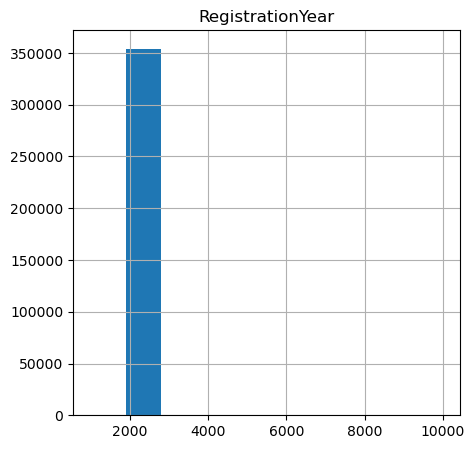

In [13]:
# cek outlier pada kolom RegsitrationYear
df.hist("RegistrationYear", figsize=(5,5))

array([[<AxesSubplot:title={'center':'Power'}>]], dtype=object)

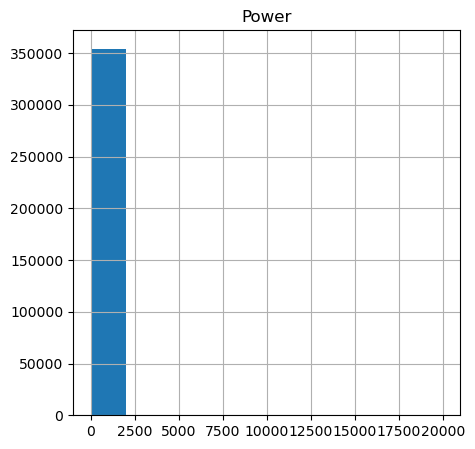

In [14]:
# cek outlier pada kolom Power
df.hist("Power", figsize=(5,5))

array([[<AxesSubplot:title={'center':'Mileage'}>]], dtype=object)

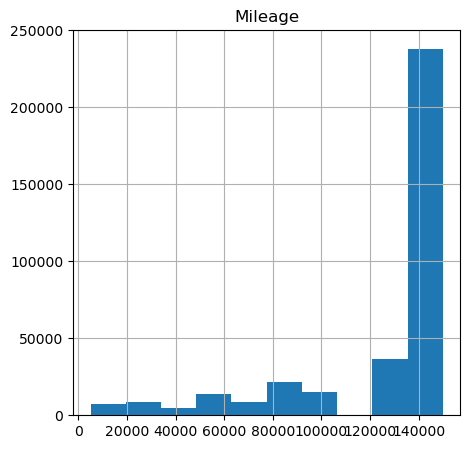

In [15]:
# cek outlier pada kolom Mileage
df.hist("Mileage", figsize=(5,5))

array([[<AxesSubplot:title={'center':'Price'}>]], dtype=object)

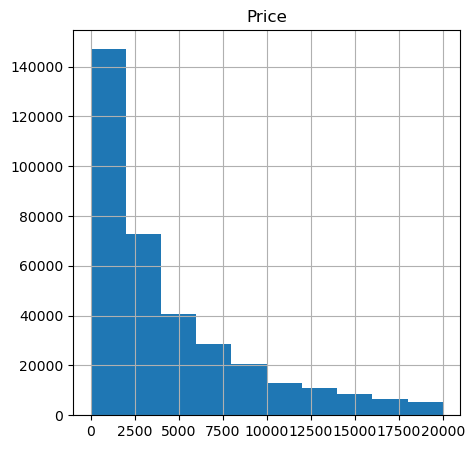

In [16]:
# cek outlier pada kolom Price
df.hist("Price", figsize=(5,5))

**Dari Informasi di atas, dapat disimpulkan:**
- Untuk kolom `RegistrationYear` terdapat nilai yang begitu tinggi yaitu nilai disekitar 2000-an. Kemungkinan kita akan mengambil data di kisaran tahun tersebut.
- Untuk kolom `Power` terdapat nilai yang cukup tinggi dikisiran 0 sampai 250. Mungkin kita akan mengambil nilai dari 100 sampai 1500. Karena mobil ekonomi dengan mesin kecil mungkin memiliki sekitar 60 hingga 100 horsepower, sementara mobil performa tinggi atau mobil balap dapat memiliki ratusan hingga ribuan horsepower.
- Untuk kolom `Mileage` terdapat nilai yang begitu melonjak di nilai 14000. Namun, ini bukanlah outlier yang begitu signifikan mengingat ada begitu banyak mobile bekas yang memiliki mileage yang begitu tinggi.
- Untuk kolom `Price` terdapat begitu banyak nilai disekitaran di bawah 2500. Untuk kolom ini, kita akan mengambil nilai yang lebih dari 0 dan nilai satuan nilainya. Karena untuk harga mobil terlalu murah bahkan hampir tidak ada harga mobil seperti itu.

## Membuat Boxplot

### Kolom Tahun

In [17]:
q1_year = df['RegistrationYear'].quantile(0.25)
q3_year = df['RegistrationYear'].quantile(0.75)
iqr_year = q3_year - q1_year
upper_bound_year = q3_year+(1.5*iqr_year)
lower_bound_year = q1_year-(1.5*iqr_year)

2021.5

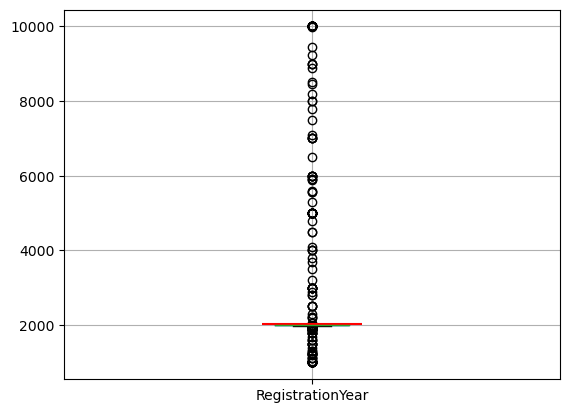

In [18]:
df.boxplot(column='RegistrationYear')
plt.hlines(y=upper_bound_year, xmin=0.9, xmax=1.1, color='red')
upper_bound_year

1985.5

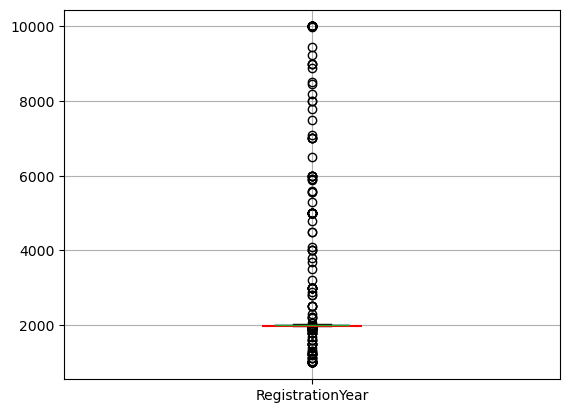

In [19]:
df.boxplot(column='RegistrationYear')
plt.hlines(y=lower_bound_year, xmin=0.9, xmax=1.1, color='red')
lower_bound_year

Kita akan mengambil data tahun dari 1986 sampai 2022. Karena berdasarkan boxplot yang kita lihat bahwa untuk batas atasnya adalah 2021.5 dan untuk batas bawah adalah 1985.5. 

### Filtering Data

In [27]:
# filtering data

# menghilangkan nilai harga tidak wajar dari kolom harga
df = df[df['Price'] > 1000]
# menghilangkan nilai tak wajar dari kolom power
df=df[(df['Power'] >= 60) & (df['Power'] <= 2000)]
# karena bulan hanya 1 sampai 12. Maka nilai 0 dihapus.
df=df[df['RegistrationMonth']!=0]
# mengambil data dari tahun 1986-2022
df=df[(df['RegistrationYear'] >= 1986) & (df['RegistrationYear'] <= 2022)]
# menghapus duplikat
df.drop_duplicates(inplace=True)

df = df.reset_index(drop=True)

In [32]:
df['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [35]:
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000',
       '911', 'None', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espa

In [36]:
df = df.drop(['Brand', 'Model'], axis=1)

In [38]:
df.shape

(222242, 14)

In [39]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Mileage,RegistrationMonth,FuelType,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 10:58:00,18300,coupe,2011,manual,190,125000,5,gasoline,yes,2016-03-24,0,66954,2016-04-07 01:46:00
1,2016-03-14 12:52:00,9800,suv,2004,auto,163,125000,8,gasoline,None,2016-03-14,0,90480,2016-04-05 12:47:00
2,2016-03-17 16:54:00,1500,small,2001,manual,75,150000,6,petrol,no,2016-03-17,0,91074,2016-03-17 17:40:00
3,2016-03-31 17:25:00,3600,small,2008,manual,69,90000,7,gasoline,no,2016-03-31,0,60437,2016-04-06 10:17:00
4,2016-04-01 20:48:00,2200,convertible,2004,manual,109,150000,8,petrol,no,2016-04-01,0,67112,2016-04-05 18:18:00


## Pelatihan Model

In [40]:
# menentukan features dan target
features = df.drop(['DateCrawled', 'Price', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
target = df['Price']
print(features.shape)
print(target.shape)

(222242, 8)
(222242,)


In [50]:
categorical = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']

# ohe
ohe = pd.get_dummies(data=features, columns=categorical, drop_first=True)

# splitting data set for XGBoost and Linear Regression
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(ohe, target, test_size=0.25,\
                                                                                            random_state=12345, shuffle=False)

# splitting data set for others model
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,\
                                                                            random_state=12345, shuffle=False)

In [51]:
numerical = ['RegistrationYear', 'Mileage', 'Power','RegistrationMonth']

# melakukan standard scaler
scaler = StandardScaler()

scaler.fit(features_train_ohe[numerical])

features_train_ohe[numerical] = scaler.transform(features_train_ohe[numerical])
features_test_ohe[numerical] = scaler.transform(features_test_ohe[numerical])

features_train[numerical] = scaler.transform(features_train[numerical])
features_test[numerical] = scaler.transform(features_test[numerical])

## Fungsi Untuk RMSE

In [52]:
def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse
scorer = make_scorer(calculate_rmse, greater_is_better=False)

## Linear Regression

In [53]:
# model linear regression
lr = LinearRegression()

In [54]:
# mengecek waktu linear regression untuk training
%time lr.fit(features_train_ohe, target_train_ohe)

Wall time: 415 ms


LinearRegression()

In [55]:
# mengecek waktu linear regression untuk memprediksi
%time lr_predict = lr.predict(features_test_ohe)

Wall time: 16 ms


In [56]:
lr_rmse = calculate_rmse(target_test_ohe, lr_predict)
lr_rmse

2860.9315954392473

Untuk model Linear Regression memiliki waktu training **415 ms** dan waktu prediksi sekitar **16 ms**. Untuk nilai RMSE nya sendiri mendapatkan hasil sekitar **2860.93**. Nilai tersebut akan dijadikan pembanding dengan model lainnya ketika melakukan sanity check

## Decision Tree

In [58]:
# melihat performa DST dari setiap depth.
for depth in range(1, 10):
    dst = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    dst_score = -cross_val_score(dst, features_train_ohe, target_train_ohe, cv=5, scoring=scorer)
    print("Depth:", depth, "Score:", dst_score.mean())

Depth: 1 Score: 3821.183885206117
Depth: 2 Score: 3370.769676586996
Depth: 3 Score: 3100.8582714425347
Depth: 4 Score: 2802.8083357217874
Depth: 5 Score: 2596.7975554498416
Depth: 6 Score: 2447.037860964498
Depth: 7 Score: 2319.808522261106
Depth: 8 Score: 2235.6846046301166
Depth: 9 Score: 2188.769757420935


Pada kedalaman ke-9 nilai terkecilnya adalah **2188.76**. Maka, kita akan memakai hyperparameter 9 untuk ke-dalaman pada Decision Tree.

**Penjelasan:** Hasil RMSE diubah menjadi nilai negatif dengan tanda negatif di depan untuk memastikan bahwa skor yang lebih rendah (lebih dekat ke nol) dianggap lebih baik dalam konteks metrik evaluasi.

In [59]:
# menggunakan DST dengan max_depth 8 dan melihat waktu pelatihan
dst = DecisionTreeRegressor(max_depth=9, random_state=12345)
%time dst.fit(features_train_ohe, target_train_ohe)

Wall time: 967 ms


DecisionTreeRegressor(max_depth=9, random_state=12345)

In [60]:
# melihat waktu prediksi DST
%time dst_prediction = dst.predict(features_test_ohe)

# nilai RMSE DST
dst_RMSE = calculate_rmse(target_test_ohe, dst_prediction)
dst_RMSE

Wall time: 32.1 ms


2171.343877212961

Nilai RMSE pada DST lebih rendah dibandingkan dengan Linear Regression. Untuk waktu yang diperlukan pada pelatihan lebih cepat dan juga pada prediksi hanya selisih beberapa ms lebih lama dari Linear Regression.

## Random Forest Regressor

In [61]:
# melihat performa RFR untuk memprediksi
for depth in range(1,10):
    rfr = RandomForestRegressor(n_estimators=50, max_depth=depth, random_state=12345)
    rfr_score = -cross_val_score(rfr, features_train_ohe, target_train_ohe, cv=5, scoring=scorer)
    print("Depth:", depth, "Score:", rfr_score.mean())

Depth: 1 Score: 3821.184379753961
Depth: 2 Score: 3351.262780699674
Depth: 3 Score: 3072.2817010337467
Depth: 4 Score: 2762.7164395205996
Depth: 5 Score: 2549.234619212476
Depth: 6 Score: 2381.7818054975287
Depth: 7 Score: 2258.5807158637886
Depth: 8 Score: 2174.202075993243
Depth: 9 Score: 2113.66288674242


Sama halnya seperti Decision Tree, pada Random Forest mendapatkan score terbaik pada kedalaman 9. Maka akan dilukakan pelatihan model dengan parameter 9 dan estimator 50.

**Penjelasan:** Hasil RMSE diubah menjadi nilai negatif dengan tanda negatif di depan untuk memastikan bahwa skor yang lebih rendah (lebih dekat ke nol) dianggap lebih baik dalam konteks metrik evaluasi.

In [62]:
rfr = RandomForestRegressor(n_estimators=50, max_depth=9, random_state=12345)
%time rfr.fit(features_train_ohe, target_train_ohe)

Wall time: 33.5 s


RandomForestRegressor(max_depth=9, n_estimators=50, random_state=12345)

In [63]:
%time rfr_predict = rfr.predict(features_test_ohe)

Wall time: 431 ms


In [64]:
rfr_RMSE = calculate_rmse(target_test_ohe, rfr_predict)
rfr_RMSE

2106.730314080672

Nilai RMSE pada Random Forest lebih baik ketimbang model Linear Regression dan Decision Tree Regressor. Tetapi waktu yang diperlukan lebih lama untuk proses training dan prediksi.

## Cat Boost

In [66]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']

# model Cat Booster
cbr = CatBoostRegressor()
parameters = {
    'depth':[5, 10],
    'learning_rate':[0.5, 0.1],
    'l2_leaf_reg':[4, 5],
    'iterations':[10, 50],
    'loss_function':['RMSE'],
    'random_seed':[12345]
}

# menentukan performa Cat Booster
grid_cv = GridSearchCV(estimator=cbr, param_grid=parameters, scoring=scorer, cv=5, n_jobs=-1, verbose=10)
grid_cv.fit(features_train, target_train, cat_features=cat_features)
best_param=grid_cv.best_params_ 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0:	learn: 3162.3773068	total: 291ms	remaining: 14.3s
1:	learn: 2583.6907882	total: 451ms	remaining: 10.8s
2:	learn: 2385.8967202	total: 613ms	remaining: 9.61s
3:	learn: 2267.0696075	total: 768ms	remaining: 8.83s
4:	learn: 2198.5658678	total: 925ms	remaining: 8.32s
5:	learn: 2167.3417679	total: 1.06s	remaining: 7.8s
6:	learn: 2126.9367478	total: 1.23s	remaining: 7.55s
7:	learn: 2097.5184668	total: 1.39s	remaining: 7.31s
8:	learn: 2078.7024168	total: 1.55s	remaining: 7.05s
9:	learn: 2071.1887624	total: 1.69s	remaining: 6.77s
10:	learn: 2062.0134764	total: 1.83s	remaining: 6.51s
11:	learn: 2048.5588647	total: 1.98s	remaining: 6.28s
12:	learn: 2040.0913383	total: 2.13s	remaining: 6.08s
13:	learn: 2030.9200526	total: 2.28s	remaining: 5.87s
14:	learn: 2024.5254695	total: 2.44s	remaining: 5.69s
15:	learn: 2014.2090424	total: 2.61s	remaining: 5.54s
16:	learn: 2007.4930693	total: 2.78s	remaining: 5.4s
17:	learn: 2004.8303880	total: 2.

In [67]:
# mengetahui nilai dan paramter terbaik
print('Skor terbaik:', -grid_cv.best_score_)
print('Parameter:', best_param)

Skor terbaik: 1937.6805326949973
Parameter: {'depth': 10, 'iterations': 50, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'loss_function': 'RMSE', 'random_seed': 12345}


**Penjelasan:** Hasil RMSE diubah menjadi nilai negatif dengan tanda negatif di depan (-grid_cv.best_score_) untuk memastikan bahwa skor yang lebih rendah (lebih dekat ke nol) dianggap lebih baik dalam konteks metrik evaluasi.

In [68]:
# mengetahui waktu training catboost
cbr = CatBoostRegressor(depth=10, iterations=50, l2_leaf_reg=4, learning_rate=0.5, loss_function='RMSE', random_seed=1234)
%time cbr.fit(features_train, target_train, cat_features=cat_features, verbose=False)

Wall time: 6.47 s


In [69]:
# mengetahui waktu prediksi catboost
%time cbr_predict = cbr.predict(features_test)

Wall time: 130 ms


In [70]:
cbr_RMSE = calculate_rmse(target_test, cbr_predict)
cbr_RMSE

1925.414017089143

Nilai yang didapatkan ketika melakukan Cat Boost adalah 1670.36. Lebih baik dari model dasar yang kita buat sebelumnya.

## LGBM

In [71]:
for i in cat_features:
    features_train[i] = features_train[i].astype('category')

# mencari parameter terbaik
lgbm_r = LGBMRegressor()
parameters_lgbm = {
    'objective':['regression_l2'],
    'num_leaves':[10, 50],
    'learning_rate':[0.5, 0.1],
    'n_estimators':[10, 20],
    'random_seed':[12345],
}

# menentukan performa LGBMRegression
grid_lgbm_r = GridSearchCV(estimator=lgbm_r, param_grid=parameters_lgbm, scoring=scorer, cv=5, n_jobs=-1)
grid_lgbm_r.fit(features_train, target_train)
best_param_lgbm = grid_lgbm_r.best_params_

In [72]:
# mengetahui nilai dan paramter terbaik
print('Skor terbaik:', -grid_lgbm_r.best_score_)
print('Parameter:', best_param_lgbm)

Skor terbaik: 1971.928319437699
Parameter: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 50, 'objective': 'regression_l2', 'random_seed': 12345}


**Penjelasan:** Hasil RMSE diubah menjadi nilai negatif dengan tanda negatif di depan (-grid_cv.best_score_) untuk memastikan bahwa skor yang lebih rendah (lebih dekat ke nol) dianggap lebih baik dalam konteks metrik evaluasi.

In [73]:
# mengetahui waktu training LGBMRegressor
lgbm_r = LGBMRegressor(objective='regression_l2', num_leaves=50, learning_rate=0.5, n_estimators=50, random_seed=12345)
%time lgbm_r.fit(features_train, target_train)

Wall time: 326 ms


LGBMRegressor(learning_rate=0.5, n_estimators=50, num_leaves=50,
              objective='regression_l2', random_seed=12345)

In [74]:
for i in cat_features:
    features_test[i] = features_test[i].astype('category')

# mengetahui waktu prediksi LGBMRegressor
%time lgbm_predict = lgbm_r.predict(features_test)

Wall time: 75.6 ms


In [75]:
lgbm_rmse = calculate_rmse(target_test, lgbm_predict)
lgbm_rmse

1908.7937793876004

Nilai yang dihasilkan oleh LightGBM lebih bagus ketimbang Cat Boost dan dari segi waktunya juga lebih cepat LightGBM dalam melatih maupun meprediksi hasil.

## XGBoost

Tidak seperti Cat Boost dan LightGBM yang bisa memprediksi menggunakan data categorical. XGBoost menggunakan data yang sudah diterapkan one-hot-encoding untuk memprediksi.

In [76]:
xgb_r = XGBRegressor()
parameter_xgb = {
    'max_depth':[3, 5, 7],
    'learning_rate':[0.5, 0.1],
    'n_estimators':[10, 20],
    'eval_metric':['rmse'],
    'seed':[12345]
}

# mengetahui performa XGBoostRegressor
grid_xgb = GridSearchCV(estimator=xgb_r, param_grid=parameter_xgb, scoring=scorer, cv=5, n_jobs=-1)
grid_xgb.fit(features_train_ohe, target_train_ohe)
best_param_xgb = grid_xgb.best_params_

In [77]:
# mengetahui nilai dan parameter terbaik 
print('Skor terbaik:', -grid_xgb.best_score_)
print('Parameter:', best_param_xgb)

Skor terbaik: 1959.4426051419632
Parameter: {'eval_metric': 'rmse', 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 20, 'seed': 12345}


**Penjelasan:** Hasil RMSE diubah menjadi nilai negatif dengan tanda negatif di depan (-grid_cv.best_score_) untuk memastikan bahwa skor yang lebih rendah (lebih dekat ke nol) dianggap lebih baik dalam konteks metrik evaluasi.

In [78]:
# mengetahui waktu training XGBoostRegressor
xgb_r = XGBRegressor(max_depth=7, learning_rate=0.5, n_estimators=20, eval_metric='rmse', seed=12345)
%time xgb_r.fit(features_train_ohe, target_train_ohe)

Wall time: 2.49 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [79]:
# mengetahui waktu prediksi XGBootRegressor
%time xgb_r_predict = xgb_r.predict(features_test_ohe)

Wall time: 51 ms


In [80]:
# menghitung nilai RMSE
xgb_RMSE = calculate_rmse(target_test_ohe, xgb_r_predict)
xgb_RMSE

1951.8224653438072

Nilai yang dihasilkan model XGBoostRegressor lebih tinggi dari model LGBM dan Cat Boost. Untuk waktunya sendiri lebih lama pada bagian training.

## Analisis Model

In [81]:
# membuat dataframe baru
data = {
    'training_time(s)':[0.415, 0.967, 33.5, 6.47, 0.326, 2.49],
    'predict_time(s)':[0.016, 0.0321, 0.431, 0.13, 0.0756, 0.051],
    'RMSE':[2860.93, 2171.43, 2106.73, 1925.41, 1908.79, 1951.82]
}
index = ['LR', 'DTR', 'RFR', 'CatBoost', 'LGBM', 'XGBoost']
model_analysis = pd.DataFrame(data=data, index=index)
model_analysis

,training_time(s),predict_time(s),RMSE
LR,0.415,0.0160,2860.93
DTR,0.967,0.0321,2171.43
RFR,33.500,0.4310,2106.73
CatBoost,6.470,0.1300,1925.41
LGBM,0.326,0.0756,1908.79
XGBoost,2.490,0.0510,1951.82


<AxesSubplot:>

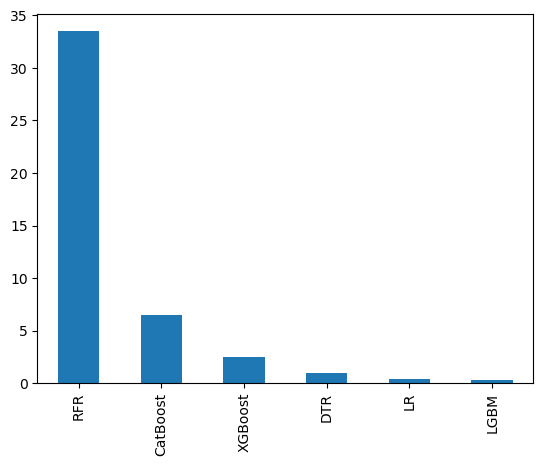

In [82]:
model_analysis['training_time(s)'].sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:>

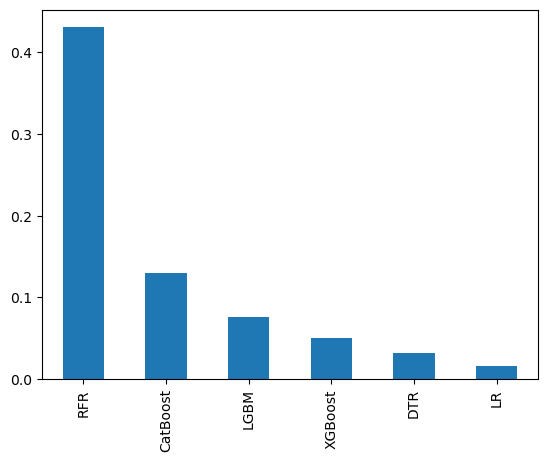

In [83]:
model_analysis['predict_time(s)'].sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:>

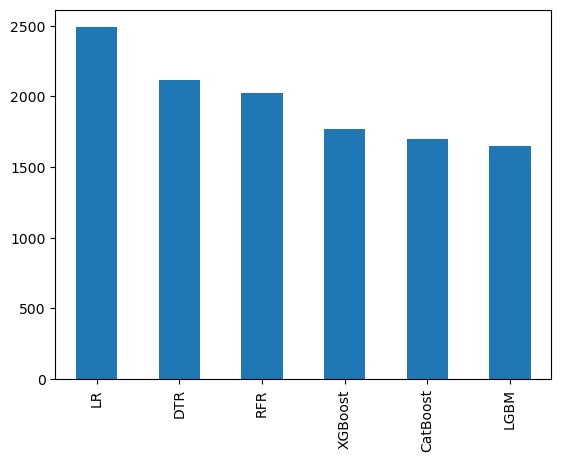

In [68]:
model_analysis['RMSE'].sort_values(ascending=False).plot(kind='bar')

**Informasi yang didapatkan:**
- Untuk waktu training, LGBM memiliki waktu training terbaik yaitu 326 ms. Sedangkan waktu training terburuk adalah model Random Forest Regressor dengan waktu 33.5 s.
- Untuk waktu prediksi, LGBM memiliki waktu prediksi terbaik yaitu 75.6 ms. Sedangkan training terburuk adalah model Random Forest Regressor dengan waktu 431 ms.
- Untuk nilai RMSE, LGBM mendapatkan nilai RMSE terendah yaitu 1908.79. Nilai ini sangat dekat dengan CatBoost yaitu 1925.41. Namun, bicara soal kefektifan model, LGBM lebih bisa untuk dipakai.

# Kesimpulan

Berdasarkan hasil yang sudah dibuat menggunakan berbagai macam model. Bisa kita simpulkan bahwa model yang memiliki performaa yang lebih bagus ketika menggunakan LightGBM. Di mana waktu training, waktu prediksi, dan nilai RMSE-nya lebih rendah ketimbang model yang lain dan metode gradient descent yang lain.

Linear Regression memiliki nilai yang tidak begitu bagus. Namun, hal ini sangat membantu ketika ingin melakukan Sanity Check.

# Daftar Periksa

Ketik 'x' untuk menandakannya sebagai selesai. Lalu, tekan tombol Shift+Enter

- [x]  Jupyter Notebook bisa dibuka
- [x]  Tidak ada kesalahan pada kode
- [x]  Sel-sel dengan kode telah disusun berdasarkan urutan eksekusi
- [x]  Data telah diunduh dan disiapkan- [ ]  Model sudah dilatih
- [x]  Analisis terhadap kecepatan dan kualitas model telah dilakukan